In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, log_loss
import graphviz
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Lambda, Reshape

/home/mirlab/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
keras.backend.image_data_format()

'channels_last'

### Helper functions

In [4]:
def loadData():
    with open('pkl_data/notes_pos.pkl', 'rb') as f:
        dpos = pickle.load(f, encoding='bytes')
    with open('pkl_data/notes_neg.pkl', 'rb') as f:
        dneg = pickle.load(f, encoding='bytes')
    return (dpos, dneg)

In [5]:
def concatFolds(pos, neg, scores):
    X_pos = np.concatenate([pos[score] for score in scores], axis=0)
    Y_pos = np.ones(X_pos.shape[0])
    X_neg = np.concatenate([neg[score] for score in scores], axis=0)
    Y_neg = np.zeros(X_neg.shape[0])
    X = np.concatenate((X_pos, X_neg), axis=0)
    Y = np.concatenate((Y_pos, Y_neg))
    return (X, Y)

In [6]:
def getTrainTestSplit(pos, neg, test_fold):
    all_folds = list(pos.keys())
    train_folds = [fold for fold in all_folds if fold != test_fold]
    (X_train, Y_train) = concatFolds(pos, neg, train_folds)
    (X_test, Y_test) = concatFolds(pos, neg, [test_fold])
    return (X_train, Y_train, X_test, Y_test)

In [7]:
def flattenImages(tensor):
    A = tensor.reshape((tensor.shape[0], -1))
    return A

In [8]:
def runCrossValidation(clf, dpos, dneg, flatten=True, pca_dims=None):

    labels = np.array([])  # ground truth labels
    preds = np.array([])  # predicted labels
    probs = np.array([])  # predicted probabilities
    clfs = []

    for score in list(dpos.keys()):

        # prep data
        (X_train, Y_train, X_test, Y_test) = getTrainTestSplit(dpos, dneg, score)
        if flatten:
            X_train = flattenImages(X_train)
            X_test = flattenImages(X_test)
        if pca_dims:
            pca = PCA(n_components=pca_dims)
            pca = pca.fit(X_train)
            X_train = pca.transform(X_train)
            X_test = pca.transform(X_test)

        # fit model
        clf = clf.fit(X_train, Y_train)
        clfs.append(clf)

        # accumulate across folds
        Y_pred = clf.predict(X_test)
        Y_prob = clf.predict_proba(X_test)
        labels = np.concatenate((labels, Y_test))
        preds = np.concatenate((preds, Y_pred))
        probs = np.concatenate((probs, Y_prob[:, 1]))

    # cumulative metrics
    acc = accuracy_score(labels, preds)
    logloss = log_loss(labels, probs)

    return (acc, logloss, clfs)

In [9]:
def showImage(X, sz=(4, 4)):
    plt.figure(figsize=sz)
    plt.imshow(1-X, cmap='gray', vmin=0, vmax=1)

### PCA Analysis

Determine number of dimensions to retain 95% of variance

In [ ]:
def calcNumPCADimensions(dpos, dneg, var):
    X_pos = np.concatenate([dpos[score] for score in list(dpos.keys())], axis=0)
    X_neg = np.concatenate([dneg[score] for score in list(dpos.keys())], axis=0)
    X_all = np.concatenate((X_pos, X_neg))
    pca = PCA()
    pca = pca.fit(flattenImages(X_all))
    cumvar = pca.explained_variance_ratio_.cumsum()
    nComponents = np.where(cumvar > var)[0][0]
    return (nComponents, pca)

In [ ]:
def visualizePCAComponents(comp, rows=4, cols=4):
    fig = plt.figure(figsize=(8, 8))
    for i in range(0, cols*rows):
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(comp[i].reshape(15, 15), cmap='gray')
        plt.title('Comp %d' % i)
    plt.show()

In [ ]:
(dpos, dneg) = loadData()
nComponents, pca = calcNumPCADimensions(dpos, dneg, .95)
nComponents

In [ ]:
visualizePCAComponents(pca.components_)

### Neural Network

In [ ]:
def runCrossValidation_keras(getModel_callback, dpos, dneg, nb_epoch=10, cnn=False):

    labels = np.array([])  # ground truth labels
    probs = np.array([])  # predicted probabilities
    models = []

    for score in sorted(dpos.keys()):

        print('Test fold %s' % score)
        (X_train, Y_train, X_test, Y_test) = getTrainTestSplit(dpos, dneg, score)
        if cnn:
            X_train = np.expand_dims(X_train, axis=3)
            X_test = np.expand_dims(X_test, axis=3)
        model = getModel_callback()
        model.fit(X_train, Y_train, nb_epoch=nb_epoch,
                  validation_data=(X_test, Y_test))
        Y_pred = model.predict(X_test)
        labels = np.concatenate((labels, Y_test))
        probs = np.concatenate((probs, np.squeeze(Y_pred)))
        models.append(model)

    acc = accuracy_score(labels, np.round(probs))
    logloss = log_loss(labels, probs)

    return (acc, logloss, models)

In [ ]:
from keras import backend as K


def get_activations2(model, layer, X_batch):
    get_activations = K.function([model.layers[0].input, K.learning_phase()], [
                                 model.layers[layer].output, ])
    activations = get_activations([X_batch, 0])
    return activations

# Logistic Regression (again)

In [ ]:
clf = LogisticRegression()
# (X_train, Y_train, X_test, Y_test) = getTrainTestSplit(dpos, dneg, score)
# clf.fit(X_train, Y_train)
(acc, logloss, clfs) = runCrossValidation(clf, dpos, dneg)
(acc, logloss)

In [ ]:
clfs[0]

In [ ]:
from scipy.signal import convolve2d

In [ ]:
#score = list(dpos.keys())[0]
for score in list(dpos.keys()):
    (X_train, Y_train, X_test, Y_test) = getTrainTestSplit(dpos, dneg, score)

In [ ]:
clf.coef_ = clf.coef_.reshape(15, 15)

Visualization is above. All we did was reshape the coefficients from a trained logistic regression to be (15,15) and convolve it together with an input image, then plot the output.

In [ ]:
import cv2
image = cv2.imread('true_piece.png', cv2.IMREAD_GRAYSCALE)
image.shape

In [ ]:
(w_width, w_height) = (15, 15)
stepSize = 5

In [ ]:
convolutions = []
counter = 0

In [ ]:
plt.imshow(image)

In [ ]:
plt.imshow(image[50:140, 100:140], cmap='gray')

In [ ]:
convolution = convolve2d(clf.coef_, image)
plt.imshow(convolution, cmap='gray')

In [ ]:
A = convolution

In [ ]:
plt.imshow(convolution[50:140, 100:140], cmap='gray')

# LR Model, 1 Conv Layer

In [ ]:
from read_activations import *

Now we'll load weights from the LR into a 1-layer CNN

In [ ]:
def getModel_convLayer():
    model = Sequential([
        Conv2D(8, 15, 15, activation='relu',
               input_shape=(842, 595, 1), name='load_LR'),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
layerOneWeights = getModel_convLayer().layers[0].get_weights()

In [ ]:
convLayer = getModel_convLayer().layers[0]

In [ ]:
model = getModel_convLayer()

In [ ]:
model.summary()

In [ ]:
layerOneWeights = getModel_convLayer().layers[0].get_weights()

In [ ]:
layerOneWeights[0].shape

In [ ]:
clf.coef_ = clf.coef_.reshape(15, 15)

In [ ]:
clf.coef_ = np.expand_dims(clf.coef_, axis=2)

In [ ]:
clf.coef_.shape

In [ ]:
weights = layerOneWeights[0]

In [ ]:
for filter_ in range(weights.shape[-1]):
    weights[:, :, :, filter_] = clf.coef_

In [ ]:
weightList = []

In [ ]:
for filter_id in range(weights.shape[-1]):
    new_weight = weights[:, :, :, filter_id].reshape(15, 15)
    weightList.append(new_weight)
    plt.imshow(new_weight)
    plt.show()

In [ ]:
plt.imshow(image)

In [ ]:
filter1_convolution = convolve2d(image, weightList[0], mode="same")
plt.imshow(filter1_convolution, cmap="gray")

In [ ]:
plt.imshow(filter1_convolution[200:400, 200:400], cmap='gray')

In [ ]:
img = image

In [ ]:
for i in range(len(weightList)):
    temp = 0
    temp = convolve2d(img, weightList[i], mode="same")
    plt.imshow(temp, cmap='gray')
    plt.show()

# 1-Layer CNN

In [ ]:
def getModel_convLayer():
    model = Sequential([
        Conv2D(8, 3, 3, activation='relu', input_shape=(15, 15, 1)),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = getModel_convLayer

In [ ]:
(acc, logloss, models) = runCrossValidation_keras(
    model, dpos, dneg, nb_epoch=5, cnn=True)

In [ ]:
getModel_convLayer().summary()

In [ ]:
models[0].save('modelTest1.h5')

In [ ]:
layerOneWeights = getModel_convLayer().layers[0].get_weights()

In [ ]:
weights = layerOneWeights[0]

In [ ]:
weightList = []

In [ ]:
for filter_id in range(weights.shape[-1]):
    new_weight = weights[:, :, :, filter_id].reshape(3, 3)
    weightList.append(new_weight)
    plt.imshow(new_weight)
    plt.show()

Below, we plot the convolution of the first filter with the image.

In [ ]:
from scipy.signal import convolve2d

In [ ]:
filter1_convolution = convolve2d(image, weightList[0], mode="same")
plt.imshow(filter1_convolution, cmap="gray")

In [ ]:
img = image

In [ ]:
for i in range(len(weightList)):
    temp = 0
    temp = convolve2d(img, weightList[i], mode="same")
    plt.imshow(temp, cmap="gray")
    plt.show()

Above is (allegedly) the image after all 8 of the filters from the conv2d layer have been applied.

# More complicated CNN

In [ ]:
def getModel_twoConvLayer():
    model = Sequential([
        Conv2D(8, 3, 3, activation='relu', input_shape=(15, 15, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(8, 3, 3, activation='relu'),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
newModel = getModel_twoConvLayer

In [ ]:
(acc, logloss, models) = runCrossValidation_keras(
    newModel, dpos, dneg, nb_epoch=5, cnn=True)

In [ ]:
getModel_twoConvLayer().summary()

In [ ]:
models[0].save('models/modelTest2.h5')

In [ ]:
layerOneWeights = getModel_twoConvLayer().layers[0].get_weights()

In [ ]:
weights = layerOneWeights[0]

In [ ]:
weightList = []

In [ ]:
for filter_id in range(weights.shape[-1]):
    new_weight = weights[:, :, :, filter_id].reshape(3, 3)
    weightList.append(new_weight)
    plt.imshow(new_weight)
    plt.show()

In [ ]:
filter1_convolution = convolve2d(image, weightList[0], mode="same")
plt.imshow(filter1_convolution, cmap="gray")

In [ ]:
img2 = image

In [ ]:
for i in range(len(weightList)):
    temp = 0
    temp = convolve2d(img2, weightList[i], mode="same")
    plt.imshow(temp, cmap='gray')
    plt.show()

Now for the second conv layer

In [ ]:
convLayerTwoWeights = getModel_twoConvLayer().layers[2].get_weights()

In [ ]:
convWeights = convLayerTwoWeights[0]

In [ ]:
weightListTwo = []

We reshape to (3,3,1,64) and apply to original image since the 64 is now the combinations of applying a layer 1 filter to original image, then a layer 2 filter to that output (8 filters x 8 filters = 64)

In [ ]:
convWeights.shape

In [ ]:
convWeights = convWeights.reshape(3, 3, 1, 64)

In [ ]:
for filter_id in range(convWeights.shape[-1]):
    new_weight = convWeights[:, :, :, filter_id].reshape(3, 3)
    weightListTwo.append(new_weight)
    plt.imshow(new_weight)
    plt.show()

In [ ]:
filter1_convolution = convolve2d(image, weightListTwo[0], mode="same")
plt.imshow(filter1_convolution, cmap="gray")

In [ ]:
img3 = image

In [ ]:
for i in range(len(weightListTwo)):
    temp = 0
    temp = convolve2d(img3, weightListTwo[i], mode="same")
    plt.imshow(temp, cmap='gray')
    plt.show()

In [ ]:
plt.imshow(img2, cmap="gray")

In [ ]:
oneConv = convolve2d(filter1_convolution, weightListTwo[0], mode="same")
plt.imshow(oneConv, cmap="gray")

# Three Layers

In [ ]:
def getModel_threeConvLayer():
    model = Sequential([
        Conv2D(8, 3, 3, activation='relu', input_shape=(15, 15, 1)),
        Conv2D(8, 3, 3, activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(16, 3, 3, activation='relu'),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
modelThree = getModel_threeConvLayer

In [ ]:
(acc, logloss, models) = runCrossValidation_keras(
    modelThree, dpos, dneg, nb_epoch=5, cnn=True)

In [ ]:
models[0].save('models/threeLayerModel.h5')

In [ ]:
layerOneWeights = getModel_threeConvLayer().layers[0].get_weights()

In [ ]:
weights = layerOneWeights[0]

In [ ]:
weightList = []

In [ ]:
for filter_id in range(weights.shape[-1]):
    new_weight = weights[:, :, :, filter_id].reshape(3, 3)
    weightList.append(new_weight)
    plt.imshow(new_weight)
    plt.show()

In [ ]:
filter1_convolution = convolve2d(image, weightList[0], mode="same")
plt.imshow(filter1_convolution, cmap="gray")

Now we'll apply all the filter of the second conv layer to the ouptut of the first filter from first conv layer.

In [ ]:
filter4_convolution = convolve2d(image, weightList[3], mode="same")
plt.imshow(filter4_convolution, cmap="gray")

In [ ]:
filter8_convolution = convolve2d(image, weightList[7], mode="same")
plt.imshow(filter8_convolution, cmap="gray")

In [ ]:
convLayerTwoWeights = getModel_threeConvLayer().layers[1].get_weights()

In [ ]:
convWeights = convLayerTwoWeights[0]

In [ ]:
convWeights.shape

In [ ]:
convWeights = convWeights.reshape(3, 3, 1, 64)

In [ ]:
weightListTwo = []

In [ ]:
for filter_id in range(convWeights.shape[-1]):
    new_weight = convWeights[:, :, :, filter_id].reshape(3, 3)
    weightListTwo.append(new_weight)
    plt.imshow(new_weight)
    plt.show()

In [ ]:
img3 = image

In [ ]:
conv2_img = convolve2d(img3, weightListTwo[0], mode="same")
plt.imshow(conv2_img, cmap='gray')

In [ ]:
for i in range(len(weightListTwo)):
    temp = 0
    temp = convolve2d(img3, weightListTwo[i], mode="same")
    plt.imshow(temp, cmap='gray')
    plt.show()

In [ ]:
convLayerThreeWeights = getModel_threeConvLayer().layers[3].get_weights()

In [ ]:
convWeights3 = convLayerThreeWeights[0]

In [ ]:
convWeights3.shape

In [ ]:
convWeights3 = convWeights3.reshape(3, 3, 1, 128)

In [ ]:
weightListThree = []

In [ ]:
for filter_id in range(convWeights3.shape[-1]):
    new_weight = convWeights3[:, :, :, filter_id].reshape(3, 3)
    weightListThree.append(new_weight)
    plt.imshow(new_weight)
    plt.show()

In [ ]:
imgThree = image

In [ ]:
for i in range(len(weightListThree)):
    temp = 0
    temp = convolve2d(imgThree, weightListThree[i], mode="same")
    plt.imshow(temp, cmap='gray')
    plt.show()

# Full Network

In [ ]:
def getModel_convcommon2():
    model = Sequential([
        BatchNormalization(input_shape=(15, 15, 1)),
        Conv2D(8, 3, 3, activation='relu', name='conv_one'),
        Conv2D(8, 3, 3, activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(8, 1, 1, activation='relu'),
        Conv2D(8, 1, 1, activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(8, 1, 1, activation='relu'),
        Conv2D(8, 1, 1, activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(225, activation='relu'),
        Dense(225, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
fullModel = getModel_convcommon2

In [ ]:
(acc, logloss, models) = runCrossValidation_keras(
    fullModel, dpos, dneg, nb_epoch=15, cnn=True)

In [ ]:
models[0].save('noteheadDetector/models/fullModel.h5')

In [ ]:
layerOneWeights = getModel_convcommon2().layers[1].get_weights()

In [ ]:
weights1 = layerOneWeights[0]

In [ ]:
weightList1 = []

In [ ]:
for filter_id in range(weights1.shape[-1]):
    new_weight = weights1[:, :, :, filter_id].reshape(3, 3)
    weightList1.append(new_weight)
    plt.imshow(new_weight)
    plt.show()

In [ ]:
imCopy = image

In [ ]:
for i in range(len(weightList1)):
    temp = 0
    temp = convolve2d(imCopy, weightList1[i], mode="same")
    plt.imshow(temp, cmap='gray')
    plt.show()

In [ ]:
layerTwoWeights = getModel_convcommon2().layers[2].get_weights()

In [ ]:
weights2 = layerTwoWeights[0]

In [ ]:
weights2.shape

In [ ]:
weights2 = weights2.reshape(3, 3, 1, 64)

In [ ]:
weightList2 = []

In [ ]:
for filter_id in range(weights2.shape[-1]):
    new_weight = weights2[:, :, :, filter_id].reshape(3, 3)
    weightList2.append(new_weight)
    plt.imshow(new_weight)
    plt.show()

In [ ]:
for i in range(len(weightList2)):
    temp = 0
    temp = convolve2d(imCopy, weightList2[i], mode="same")
    plt.imshow(temp, cmap='gray')
    plt.show()

In [ ]:
layerThreeWeights = getModel_convcommon2().layers[4].get_weights()

In [ ]:
weights3 = layerThreeWeights[0]

In [ ]:
weights3.shape

In [ ]:
weights3 = weights3.reshape(1, 1, 1, 64)

In [ ]:
weightList3 = []

In [ ]:
for filter_id in range(weights3.shape[-1]):
    new_weight = weights3[:, :, :, filter_id].reshape(1, 1)
    weightList3.append(new_weight)
    plt.imshow(new_weight)
    plt.show()

In [ ]:
for i in range(len(weightList3)):
    temp = 0
    temp = convolve2d(imCopy, weightList3[i], mode="same")
    plt.imshow(temp, cmap='gray')
    plt.show()

In [ ]:
layerFourWeights = getModel_convcommon2().layers[5].get_weights()

In [ ]:
weights4 = layerFourWeights[0]

In [ ]:
weights4.shape

In [ ]:
weights4 = weights4.reshape(1, 1, 1, 64)

In [ ]:
weightList4 = []

In [ ]:
for filter_id in range(weights4.shape[-1]):
    new_weight = weights4[:, :, :, filter_id].reshape(1, 1)
    weightList4.append(new_weight)
    plt.imshow(new_weight)
    plt.show()

In [ ]:
for i in range(len(weightList4)):
    temp = 0
    temp = convolve2d(imCopy, weightList4[i], mode="same")
    plt.imshow(temp, cmap='gray')
    plt.show()

In [ ]:
lastLayerWeights = getModel_convcommon2().layers[8].get_weights()

In [ ]:
weights6 = lastLayerWeights[0]

In [ ]:
weights6.shape

In [ ]:
weights6 = weights6.reshape(1, 1, 1, 64)

In [ ]:
weightList6 = []

In [ ]:
for filter_id in range(weights6.shape[-1]):
    new_weight = weights6[:, :, :, filter_id].reshape(1, 1)
    weightList6.append(new_weight)
    plt.imshow(new_weight)
    plt.show()

In [ ]:
for i in range(len(weightList6)):
    temp = 0
    temp = convolve2d(imCopy, weightList6[i], mode="same")
    plt.imshow(temp, cmap='gray')
    plt.show()

# Mek's experiment

## Setup the model
Manually checked the model has been loaded correctly.

In [10]:
model = keras.models.load_model('noteheadDetector/models/cnn8.h5')

## Get the full sheet music

In [11]:
import cv2

(842, 595)


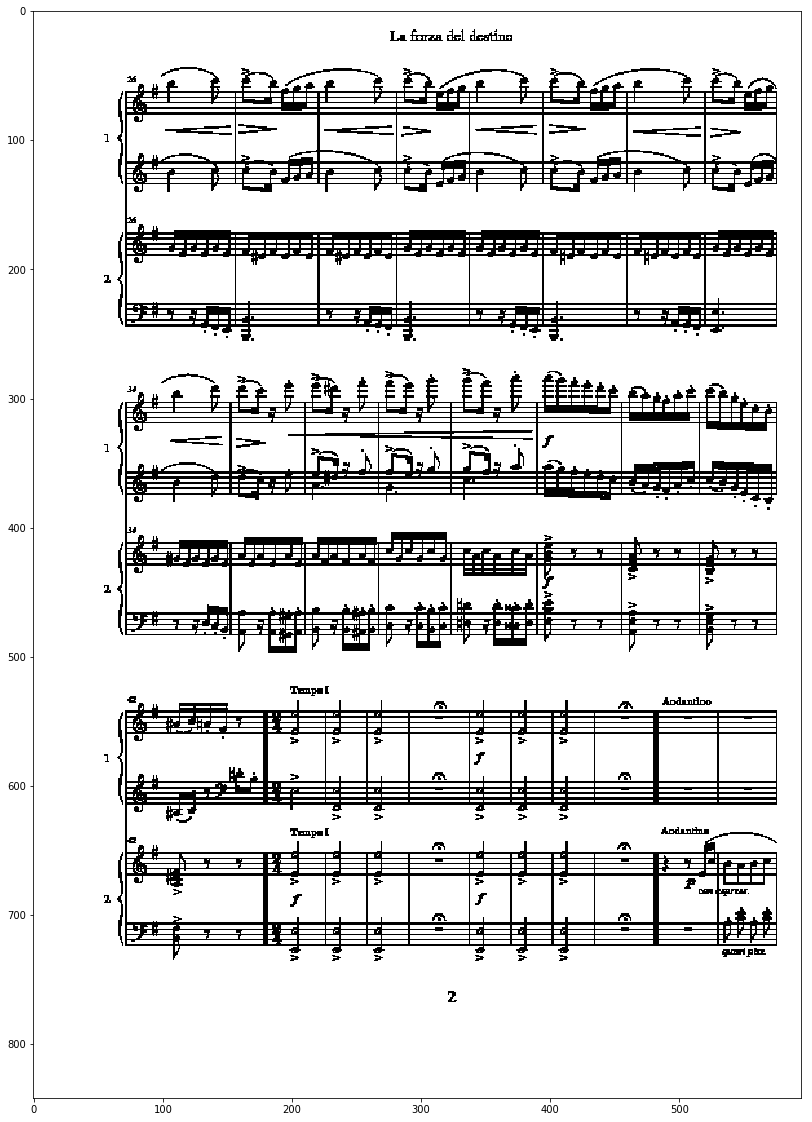

In [12]:
image = cv2.imread('true_piece.png', cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(20,20))
plt.imshow(image, cmap='gray')
print(image.shape)

## Check Training data

In [35]:
with open('noteheadDetector/pkl_data/notes_pos.pkl','rb') as f:
    dpos = pickle.load(f, encoding='bytes')
with open('noteheadDetector/pkl_data/notes_neg.pkl','rb') as f:
    dneg = pickle.load(f, encoding='bytes')

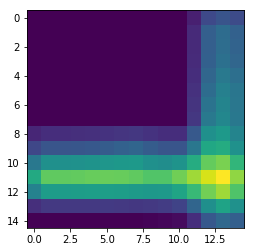

In [36]:
plt.imshow(dneg[b'score1'][1])

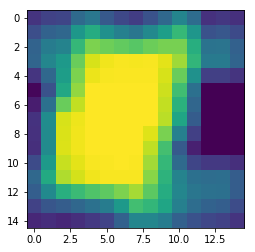

In [37]:
plt.imshow(dpos[b'score1'][100])

In [38]:
model.predict(dpos[b'score1'][100].reshape(1,15,15,1))

array([[0.9473098]], dtype=float32)

## Modified model

In [13]:
import tensorflow as tf
from keras import backend as K

In [14]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5

In [15]:
img = tf.placeholder(tf.float32, shape=(1, None, None, 1))
img_slides = tf.extract_image_patches(img,
                                      [1,15,15,1], 
                                      [1,1,1,1], 
                                      [1,1,1,1], 
                                      'VALID')

x = K.reshape(img_slides, [-1,15,15,1])
y = model(x)

In [114]:
image = 255 - cv2.imread('true_piece.png', cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
image = image[0:500,0:500]

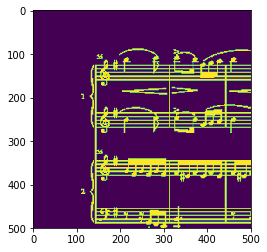

In [115]:
plt.imshow(image)

In [116]:
img_shape = image.shape
img_reshaped = image.reshape(1, img_shape[0], img_shape[1], 1)

with tf.Session(config=config).as_default() as sess:
#     run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
#     sess = tf_debug.TensorBoardDebugWrapperSession(sess, "mirlab:6000")model
    model.load_weights('noteheadDetector/models/cnn8.h5')
    output_vals = sess.run(y, {img: img_reshaped,
                               K.learning_phase(): 0})

In [117]:
output_vals = output_vals.reshape((image.shape[0]-14, image.shape[1]-14))

In [118]:
output_vals

array([[0.00037366, 0.00037366, 0.00037366, ..., 0.00037366, 0.00037366,
        0.00037366],
       [0.00037366, 0.00037366, 0.00037366, ..., 0.00037366, 0.00037366,
        0.00037366],
       [0.00037366, 0.00037366, 0.00037366, ..., 0.00037366, 0.00037366,
        0.00037366],
       ...,
       [0.00037366, 0.00037366, 0.00037366, ..., 0.        , 0.        ,
        0.        ],
       [0.00037366, 0.00037366, 0.00037366, ..., 0.        , 0.        ,
        0.        ],
       [0.00037366, 0.00037366, 0.00037366, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [119]:
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

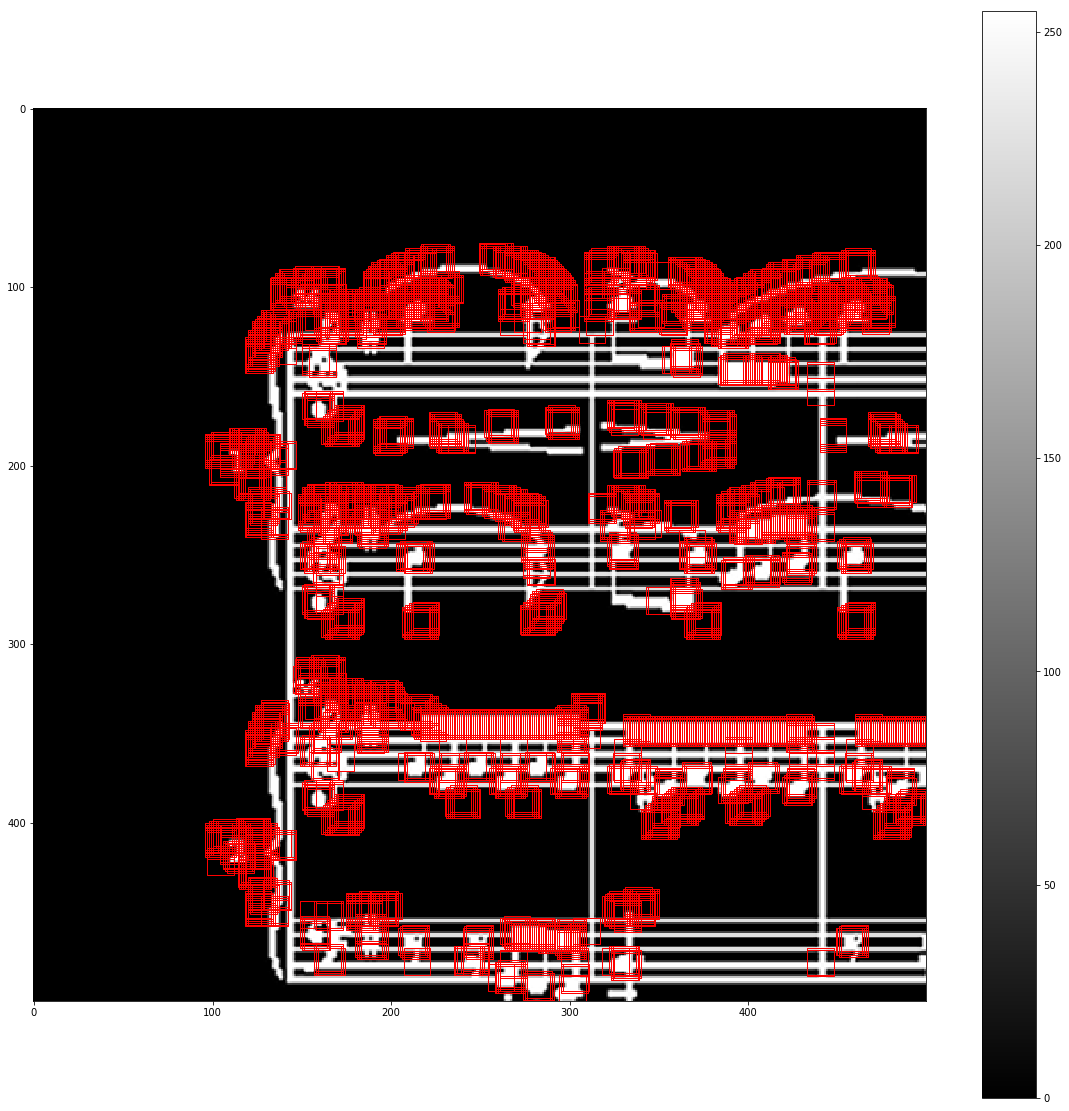

In [121]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,1,1)
plt.imshow(image, cmap='gray', alpha=1.0)
boxes = []
for row in range(output_vals.shape[0]):
    for col in range(output_vals.shape[1]):
        if output_vals[row,col] > 0.95:
            boxes.append(Rectangle((col,row), 15, 15, color='red', alpha=0.5))

pc = PatchCollection(boxes, alpha=1.0, facecolor='None', edgecolor='red')
ax.add_collection(pc)
plt.colorbar()
plt.show()

In [122]:
model.layers